# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from numpy import asarray
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.impute import SimpleImputer
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Dense, Dropout
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

## View dataset

In [2]:
dataset = pd.read_csv('stops_enriched_with_clusters.csv')
pd.set_option('display.max_columns', None)
dataset.head()

,stop_id,stop_name,stop_lat,stop_lon,postcode,oa21cd,lsoa21cd,lsoa21nm,shops_nearby_count,population_density,oa21pop,postcode_pop,employed_total,bus_commute_total,avg_weekly_frequency_per_hour,customer_convenience_score,commute_opportunity_score,cluster,cluster_category
0,2200YEA00378,Hessle Boothferry Road,53.732380,-0.434509,HU13 9AT,E00065616,E01013013,East Riding of Yorkshire 034C,1,2696.269287,255.0,36.0,132.0,0.0,1.035443,0.4196,0.4201,0,Low-Density Residential/Rural
1,2200YEA00936,Hessle Darleys,53.732969,-0.435579,HU13 9AT,E00065616,E01013013,East Riding of Yorkshire 034C,1,2696.269287,255.0,36.0,132.0,0.0,1.000000,0.4182,0.4201,0,Low-Density Residential/Rural
2,2290YHA00591,Hessle Road Fire Station,53.725595,-0.416194,HU4 7BG,E00064998,E01012884,Kingston upon Hull 033C,13,2727.012451,228.0,21.0,97.0,8.0,1.959743,0.6238,0.7005,0,Low-Density Residential/Rural
3,2290YHA00976,Winship Close,53.739096,-0.358721,HU3 2QN,E00064825,E01012855,Kingston upon Hull 029D,15,6503.278809,374.0,24.0,129.0,8.0,2.561829,0.6712,0.7247,0,Low-Density Residential/Rural
4,2200YEA00977,Coniston Hull Road,53.797082,-0.248579,HU11 4LD,E00065744,E01013032,East Riding of Yorkshire 021D,1,84.610626,322.0,47.0,176.0,0.0,0.990257,0.3515,0.4447,2,High-Density Residential


# 1. Data Preprocessing
## 1.1 Build X and y

In [3]:
X_features = ['shops_nearby_count', 'population_density', 'oa21pop', 'employed_total', 'bus_commute_total', 'customer_convenience_score', 'commute_opportunity_score']
y = dataset['avg_weekly_frequency_per_hour']
X = dataset[X_features]
X_y_features = X_features + ['avg_weekly_frequency_per_hour']
X_and_y = dataset[X_y_features]

In [4]:
X.head()

,shops_nearby_count,population_density,oa21pop,postcode_pop,employed_total,bus_commute_total,customer_convenience_score,commute_opportunity_score
0,1,2696.269287,255.0,36.0,132.0,0.0,0.4196,0.4201
1,1,2696.269287,255.0,36.0,132.0,0.0,0.4182,0.4201
2,13,2727.012451,228.0,21.0,97.0,8.0,0.6238,0.7005
3,15,6503.278809,374.0,24.0,129.0,8.0,0.6712,0.7247
4,1,84.610626,322.0,47.0,176.0,0.0,0.3515,0.4447


In [5]:
y.head()

0    1.035443
1    1.000000
2    1.959743
3    2.561829
4    0.990257
Name: avg_weekly_frequency_per_hour, dtype: float64

## 1.2 Normalize y for MSE, MAE, and RMSE consistency

In [6]:
scaler = MinMaxScaler()
columns_ = X_y_features
X_and_y_normalized_np = scaler.fit_transform(X_and_y)
X_and_y_normalized = pd.DataFrame(X_and_y_normalized_np, columns=columns_)
y_normalized = X_and_y_normalized['avg_weekly_frequency_per_hour']
y_normalized.head()

0    0.066434
1    0.063557
2    0.141460
3    0.190332
4    0.062766
Name: avg_weekly_frequency_per_hour, dtype: float64

## 1.3 Check for missing values in X and y

In [7]:
total = X.isnull().sum()
percent = (X.isnull().sum()\
           /X.isnull().count()*100)
pd.concat([total, percent], axis=1, \
          keys=['Total', 'Percent']).transpose() 

,shops_nearby_count,population_density,oa21pop,postcode_pop,employed_total,bus_commute_total,customer_convenience_score,commute_opportunity_score
Total,0.0,0.0,0.0,444.000000,0.0,1.000000,0.0,0.0
Percent,0.0,0.0,0.0,11.890734,0.0,0.026781,0.0,0.0


In [8]:
print(f"Number of missing values in 'y': {y_normalized.isnull().sum()}")

Number of missing values in 'y': 30


## 1.4 Impute those values with the mean of its column

In [9]:
imputer_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
columns_ = X_features
X_clean_np = imputer_mean.fit_transform(X)
X_clean = pd.DataFrame(X_clean_np, columns=columns_)
X_clean.head()

,shops_nearby_count,population_density,oa21pop,postcode_pop,employed_total,bus_commute_total,customer_convenience_score,commute_opportunity_score
0,1.0,2696.269287,255.0,36.0,132.0,0.0,0.4196,0.4201
1,1.0,2696.269287,255.0,36.0,132.0,0.0,0.4182,0.4201
2,13.0,2727.012451,228.0,21.0,97.0,8.0,0.6238,0.7005
3,15.0,6503.278809,374.0,24.0,129.0,8.0,0.6712,0.7247
4,1.0,84.610626,322.0,47.0,176.0,0.0,0.3515,0.4447


In [10]:
mean_y = y_normalized.mean()
y_clean = y_normalized.fillna(mean_y)
y_normalized = y_clean

Number of missing values in 'y': 0


## 1.5 Confirm no missing values

In [11]:
total = X_clean.isnull().sum()
percent = (X_clean.isnull().sum()\
           /X_clean.isnull().count()*100)
pd.concat([total, percent], axis=1, \
          keys=['Total', 'Percent']).transpose() 

,shops_nearby_count,population_density,oa21pop,postcode_pop,employed_total,bus_commute_total,customer_convenience_score,commute_opportunity_score
Total,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
print(f"Number of missing values in 'y': {y_normalized.isnull().sum()}")

Number of missing values in 'y': 0


# 2. Model Implementation and Evalutation
## Linear Regression Model

## 2.1 View scale of data against each other

<Axes: >

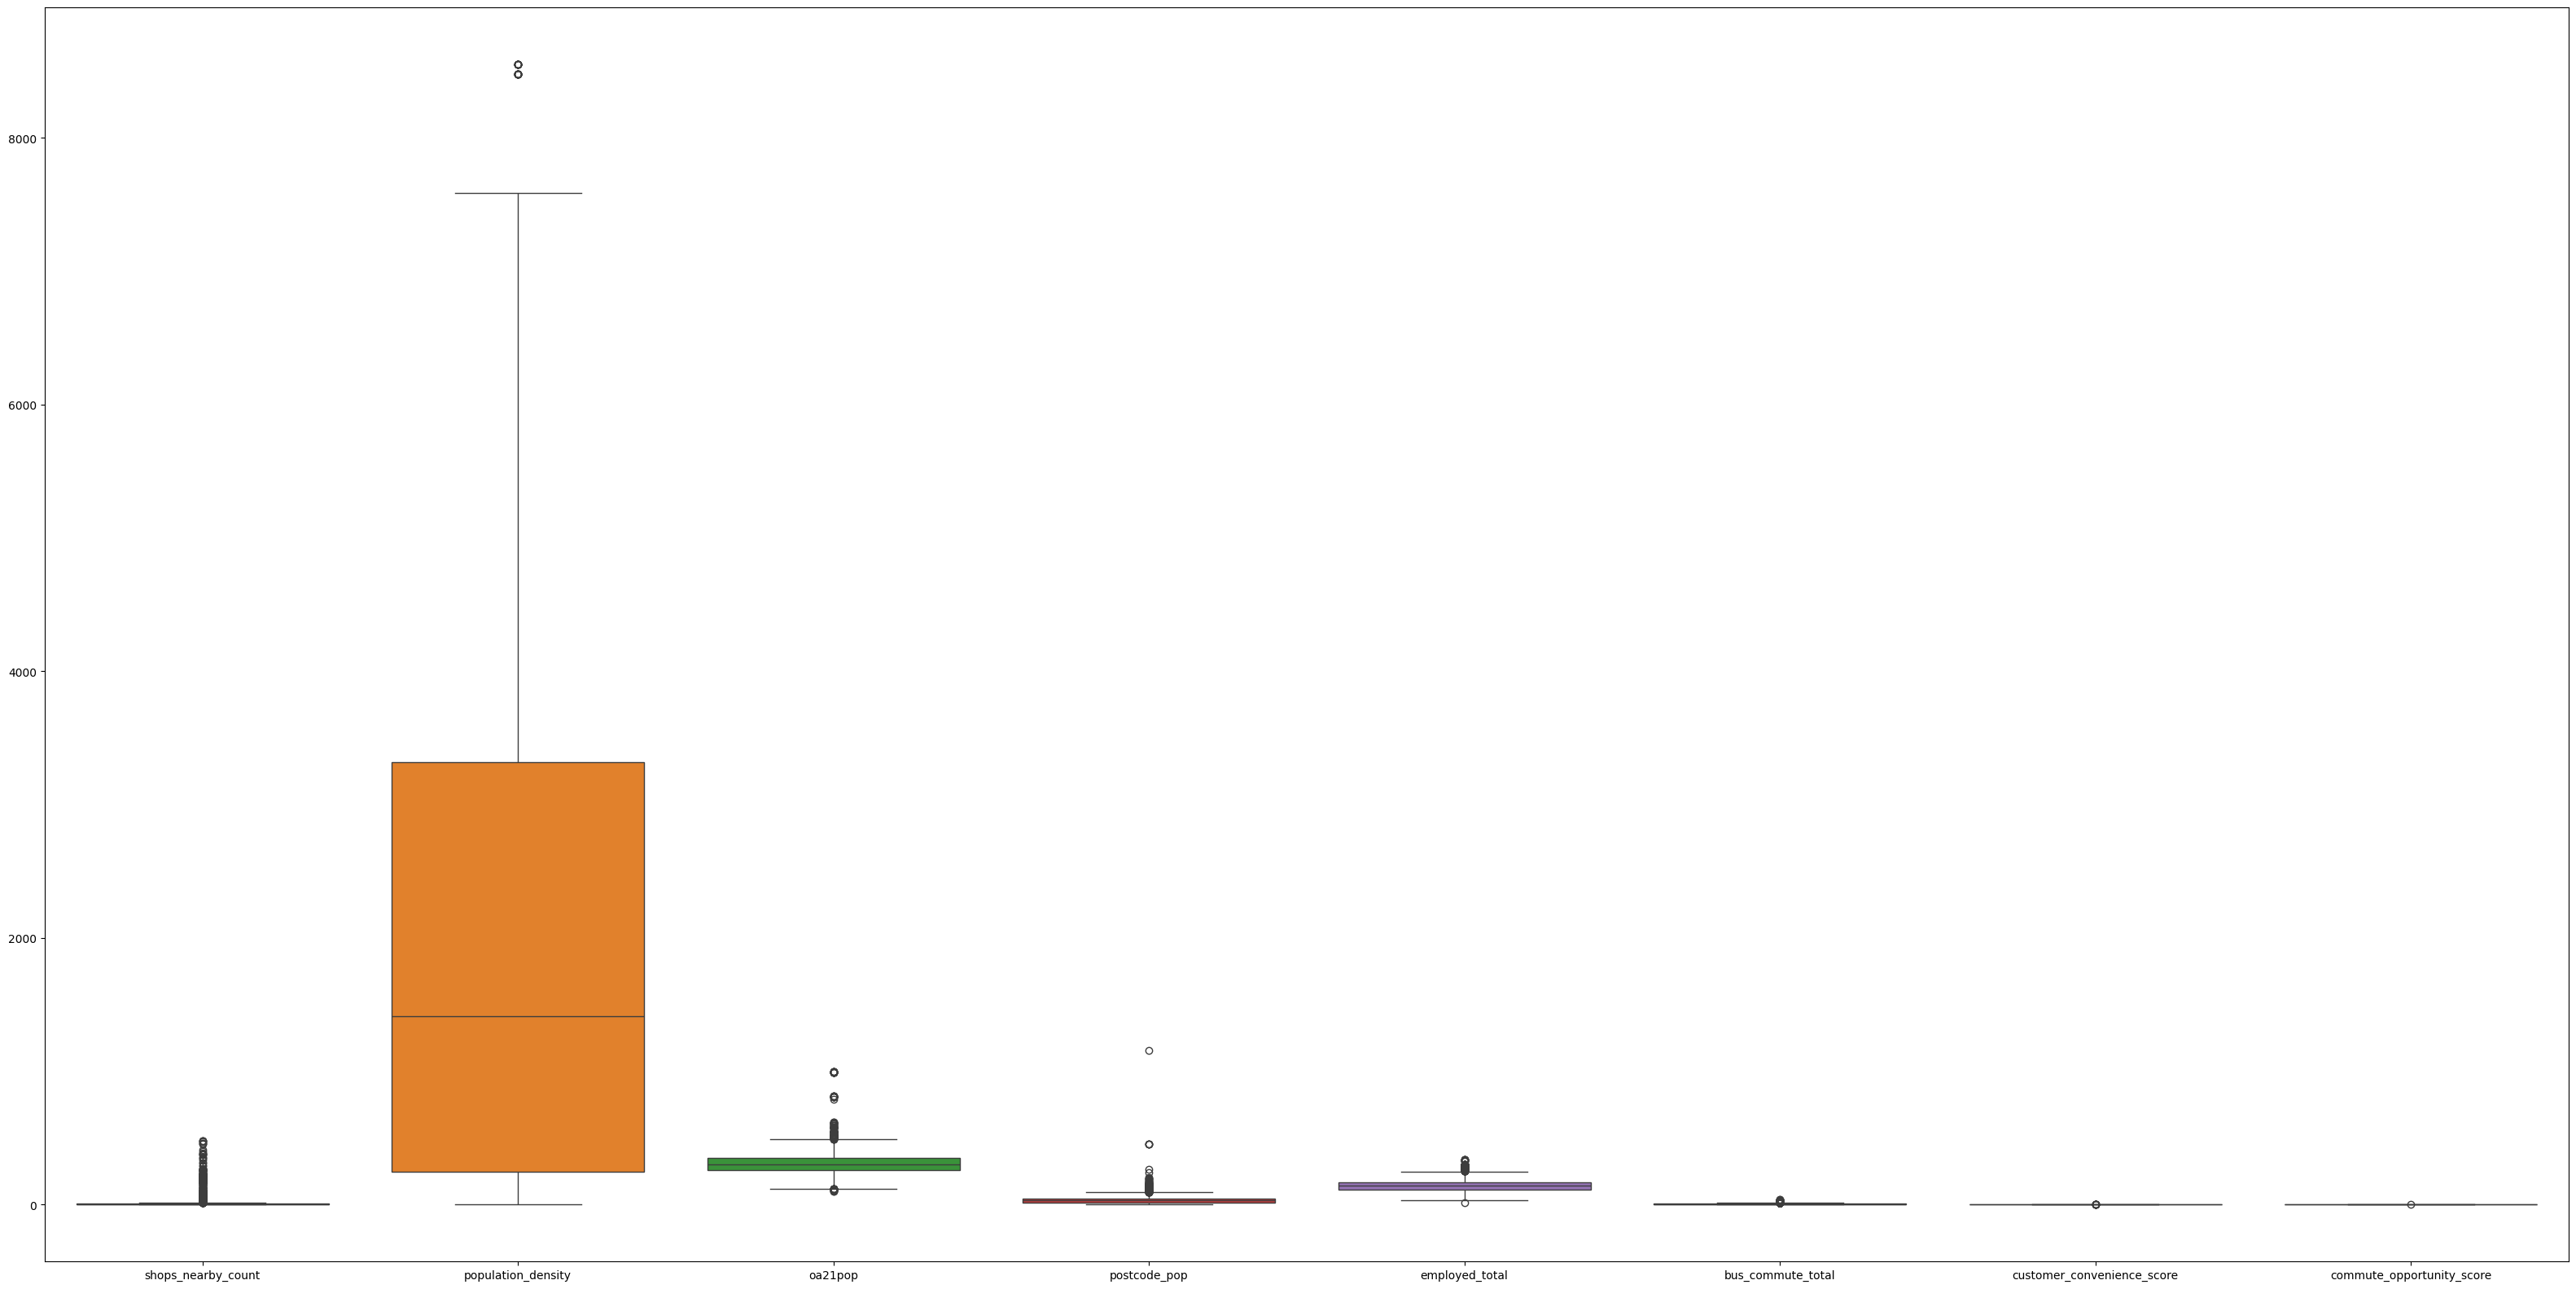

In [12]:
plt.figure(figsize=(40,20))
sns.boxplot(data=X_clean)

## 2.2 Normalize Data

In [13]:
scaler = MinMaxScaler()

X_normalized_np = scaler.fit_transform(X_clean)
X_normalized = pd.DataFrame(X_normalized_np, columns=columns_)
X_normalized.head()

,shops_nearby_count,population_density,oa21pop,postcode_pop,employed_total,bus_commute_total,customer_convenience_score,commute_opportunity_score
0,0.002096,0.315334,0.173526,0.030251,0.372308,0.000000,0.304027,0.438838
1,0.002096,0.315334,0.173526,0.030251,0.372308,0.000000,0.301999,0.438838
2,0.027254,0.318930,0.143493,0.017286,0.264615,0.228571,0.599797,0.731746
3,0.031447,0.760571,0.305895,0.019879,0.363077,0.228571,0.668453,0.757025
4,0.002096,0.009895,0.248053,0.039758,0.507692,0.000000,0.205388,0.464536


## 2.3 View normalized data to ensure no bias

<Axes: >

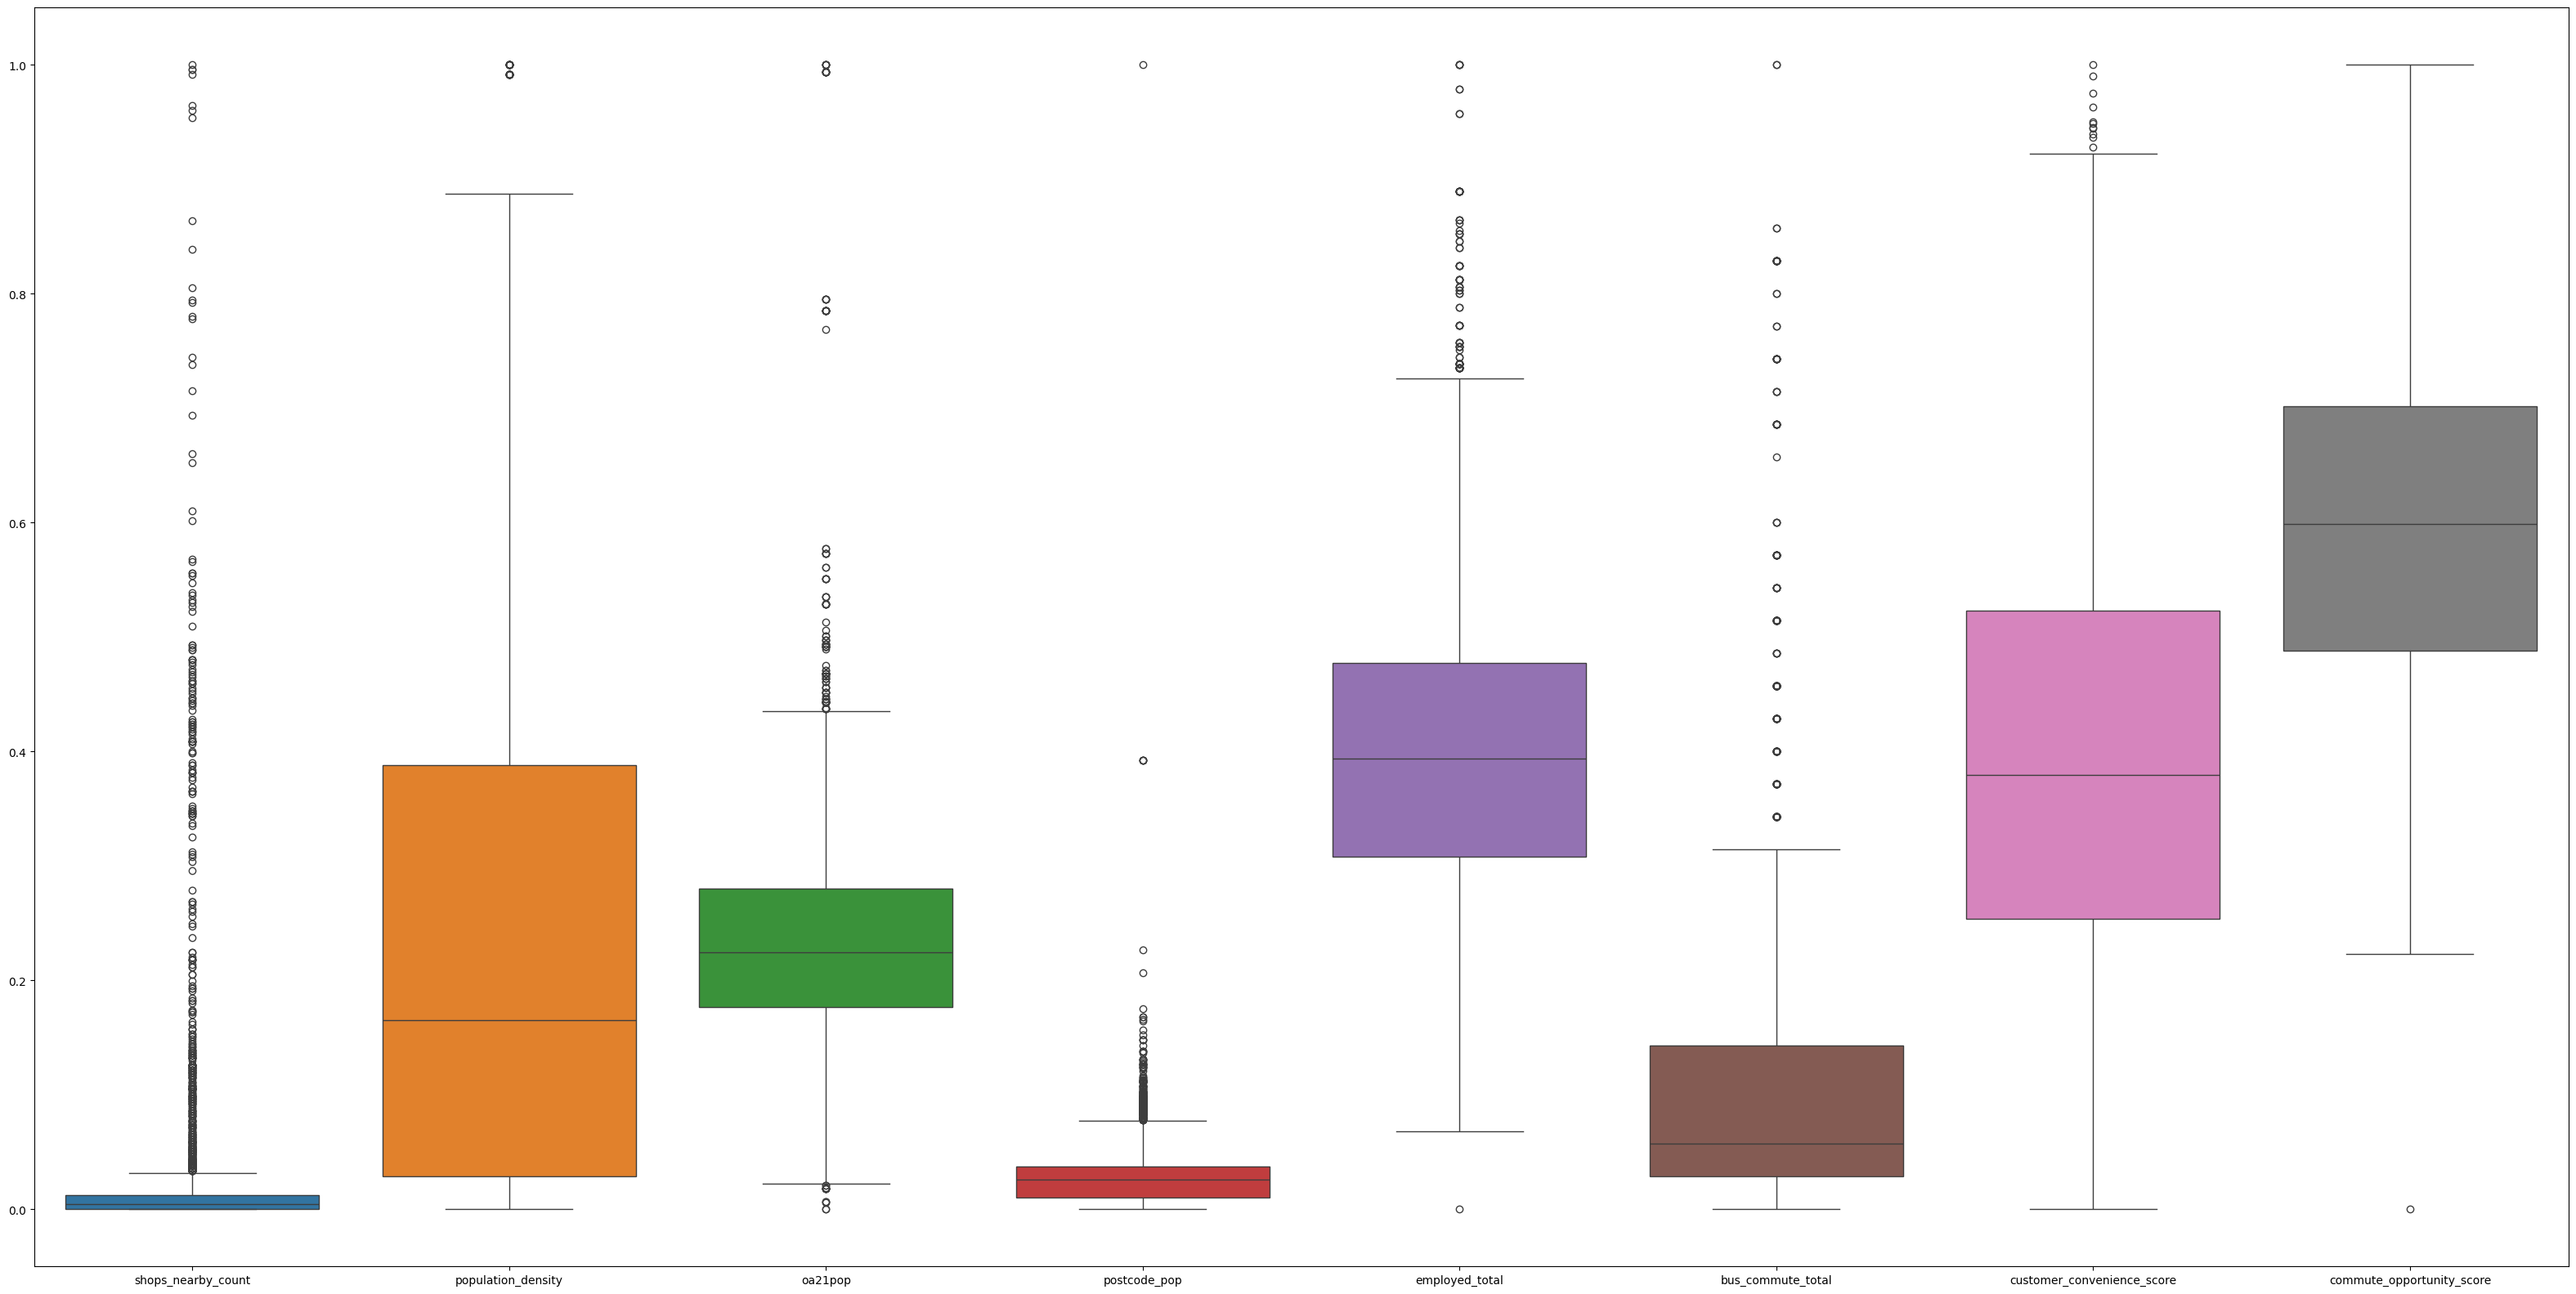

In [14]:
plt.figure(figsize=(40,20))
sns.boxplot(data=X_normalized)

## 2.4 80-20 Data Split

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_normalized, test_size=0.2, random_state=0)

## 2.5 Fitting the Multiple Linear Regression Model

In [16]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

## 2.6 Mapping Predicted v Actual Values

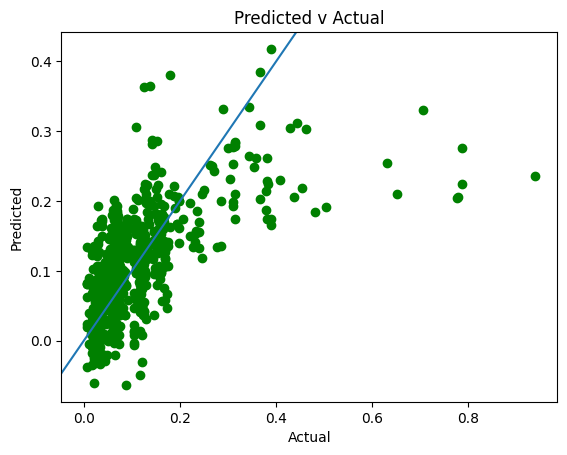

In [17]:
y_pred = regressor.predict(X_test)

plt.scatter(y_test, y_pred,color='g') 
plt.title('Predicted v Actual')
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.axline((0, 0), slope=1)

plt.show()

## 2.7 Producing statistical test outputs

In [18]:
linear_mae = metrics.mean_absolute_error(y_test, y_pred)
linear_mse = metrics.mean_squared_error(y_test, y_pred)
linear_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print('Mean Absolute Error:', linear_mae)
print('Mean Squared Error:', linear_mse)
print('Root Mean Squared Error:', linear_rmse)

Mean Absolute Error: 0.052258902103467
Mean Squared Error: 0.006987775256426456
Root Mean Squared Error: 0.0835929139127621


## Polynomial Regression Model
## 2.8 Standardizing Data

In [19]:
scaler = StandardScaler()

X_standard_np = scaler.fit_transform(X_clean)
X_standard = pd.DataFrame(X_standard_np, columns=columns_)
X_standard.head()

,shops_nearby_count,population_density,oa21pop,postcode_pop,employed_total,bus_commute_total,customer_convenience_score,commute_opportunity_score
0,-0.286557,0.342702,-0.609587,0.006099,-0.223415,-0.748289,-0.520467,-1.230432
1,-0.286557,0.342702,-0.609587,0.006099,-0.223415,-0.748289,-0.531640,-1.230432
2,-0.021977,0.358011,-0.903527,-0.396261,-1.004657,0.903855,1.109260,0.939078
3,0.022119,2.238483,0.685927,-0.315789,-0.290379,0.903855,1.487561,1.126318
4,-0.286557,-0.957829,0.119820,0.301162,0.758717,-0.748289,-1.063975,-1.040097


I never ended up using the standardized data above as it had an adverse affect on the model.

## 2.9 80-20 Split

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_clean, y_normalized, test_size=0.2, random_state=0)

## 2.10 Fitting the Polynomial Regression Model

In [21]:
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X_train)
regressor = LinearRegression()
regressor.fit(X_poly, y_train)

LinearRegression()

## 2.11 Mapping Predicted v Actual Values

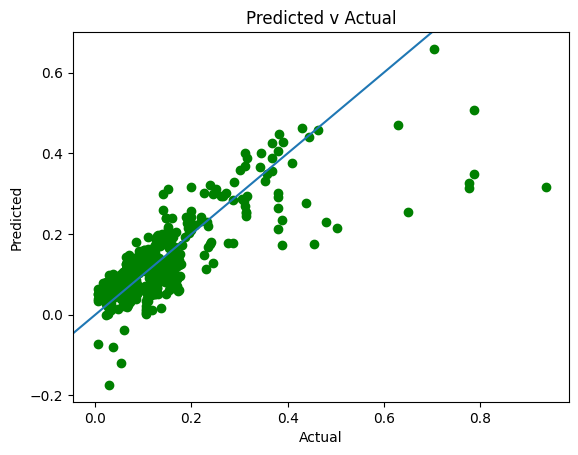

In [22]:
X_poly_test = poly_features.fit_transform(X_test)
y_pred = regressor.predict(X_poly_test)

plt.scatter(y_test, y_pred,color='g')
plt.title('Predicted v Actual')
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.axline((0, 0), slope=1)
plt.ticklabel_format(style='plain')
plt.show()

## 2.12 Producing Statistical test outputs

In [23]:
poly_mae = metrics.mean_absolute_error(y_test, y_pred)
poly_mse = metrics.mean_squared_error(y_test, y_pred)
poly_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred)) 
print('Mean Absolute Error:', poly_mae)
print('Mean Squared Error:', poly_mse)
print('Root Mean Squared Error:', poly_rmse)

Mean Absolute Error: 0.03751023269291291
Mean Squared Error: 0.0038392524135730088
Root Mean Squared Error: 0.06196170118365867


## Neural Network Model

## 2.13 Split Data into train, test, and validation sets

In [24]:
X_new, X_test, y_new, y_test = train_test_split(X_normalized, y_normalized, test_size=0.2, random_state=0)
dev_per = X_test.shape[0]/X_new.shape[0]
X_train, X_dev, y_train, y_dev = train_test_split(X_new, y_new, test_size=dev_per, random_state=0)

## 2.14 Using a linear output (essentially linear regression)

In [25]:
model = Sequential([
    Dense(1, activation='linear', input_shape=(8,)),
])
optimizer = "sgd"
model.compile(optimizer= optimizer,
              loss='mean_squared_error')

hist = model.fit(X_train, y_train,
          batch_size=128, epochs=150,
          validation_data=(X_dev, y_dev))



Epoch 1/150

18/18 [==============================] - 0s 9ms/step - loss: 0.0516 - val_loss: 0.0390
Epoch 2/150
18/18 [==============================] - 0s 2ms/step - loss: 0.0441 - val_loss: 0.0353
Epoch 3/150
18/18 [==============================] - 0s 3ms/step - loss: 0.0410 - val_loss: 0.0335
Epoch 4/150
18/18 [==============================] - 0s 3ms/step - loss: 0.0392 - val_loss: 0.0322
Epoch 5/150
18/18 [==============================] - 0s 2ms/step - loss: 0.0377 - val_loss: 0.0310
Epoch 6/150
18/18 [==============================] - 0s 3ms/step - loss: 0.0364 - val_loss: 0.0299
Epoch 7/150
18/18 [==============================] - 0s 3ms/step - loss: 0.0352 - val_loss: 0.0288
Epoch 8/150
18/18 [==============================] - 0s 3ms/step - loss: 0.0340 - val_loss: 0.0279
Epoch 9/150
18/18 [==============================] - 0s 2ms/step - loss: 0.0329 - val_loss: 0.0269
Epoch 10/150
18/18 [==============================] - 0s 3ms/step - loss: 0.0318 - val_loss: 0.0260
Epoch 

## 2.15 Modelling the reduction in MSE over each epoch

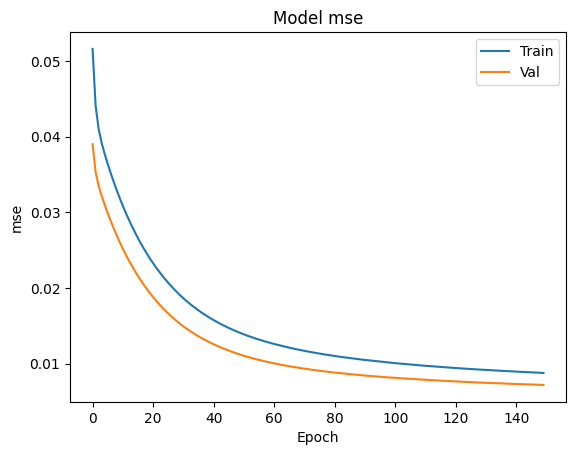

In [26]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model mse')
plt.ylabel('mse')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

## 2.16 Predicted v Actual values

24/24 [==============================] - 0s 797us/step


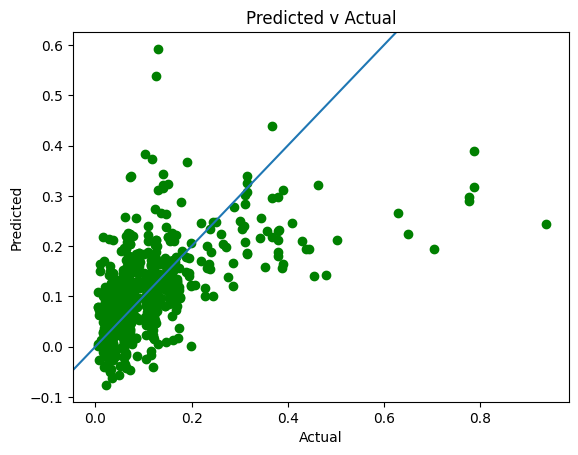

In [27]:
y_pred =  model.predict(X_test)
plt.scatter(y_test, y_pred,color='g')
plt.title('Predicted v Actual')
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.axline((0, 0), slope=1)
plt.ticklabel_format(style='plain')
plt.show()

## 2.17 Producing Statistical Tests

In [28]:
neural_linear_mae = metrics.mean_absolute_error(y_test, y_pred)
neural_linear_mse = metrics.mean_squared_error(y_test, y_pred)
neural_linear_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print('Mean Absolute Error:', neural_linear_mae)
print('Mean Squared Error:', neural_linear_mse)
print('Root Mean Squared Error:', neural_linear_rmse)

Mean Absolute Error: 0.05954717885474822
Mean Squared Error: 0.008406252711130173
Root Mean Squared Error: 0.09168561888938839


## 2.18 Producing a more complex neural net

In [29]:
model = Sequential([
    Dense(32, activation='relu', input_shape=(8,)),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(8, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam',
              loss='mean_squared_error')

hist = model.fit(X_train, y_train,
                 batch_size=128, epochs=50,
                 validation_data=(X_dev, y_dev))

Epoch 1/50
18/18 [==============================] - 1s 10ms/step - loss: 0.0143 - val_loss: 0.0092
Epoch 2/50
18/18 [==============================] - 0s 3ms/step - loss: 0.0095 - val_loss: 0.0077
Epoch 3/50
18/18 [==============================] - 0s 4ms/step - loss: 0.0088 - val_loss: 0.0077
Epoch 4/50
18/18 [==============================] - 0s 3ms/step - loss: 0.0085 - val_loss: 0.0074
Epoch 5/50
18/18 [==============================] - 0s 4ms/step - loss: 0.0084 - val_loss: 0.0075
Epoch 6/50
18/18 [==============================] - 0s 2ms/step - loss: 0.0078 - val_loss: 0.0076
Epoch 7/50
18/18 [==============================] - 0s 3ms/step - loss: 0.0082 - val_loss: 0.0071
Epoch 8/50
18/18 [==============================] - 0s 3ms/step - loss: 0.0079 - val_loss: 0.0073
Epoch 9/50
18/18 [==============================] - 0s 3ms/step - loss: 0.0076 - val_loss: 0.0066
Epoch 10/50
18/18 [==============================] - 0s 3ms/step - loss: 0.0074 - val_loss: 0.0061
Epoch 11/50
18/18 

## 2.19 Modelling the reduction of MSE over each epoch

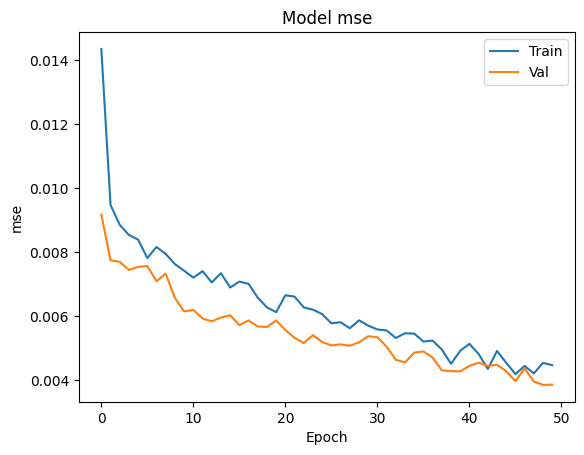

In [30]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model mse')
plt.ylabel('mse')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

## 2.20 Predicted v Actual values

24/24 [==============================] - 0s 719us/step


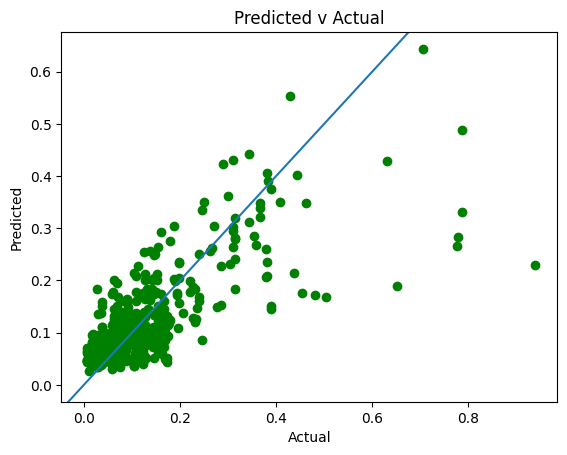

In [31]:
y_pred =  model.predict(X_test)
plt.scatter(y_test, y_pred,color='g')
plt.title('Predicted v Actual')
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.axline((0, 0), slope=1)
plt.ticklabel_format(style='plain')
plt.show()

## 2.21 Producing Statistical Tests

In [32]:
neural_net_mae = metrics.mean_absolute_error(y_test, y_pred)
neural_net_mse = metrics.mean_squared_error(y_test, y_pred)
neural_net_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.04069174916306851
Mean Squared Error: 0.004792897837444733
Root Mean Squared Error: 0.06923075788581787


## 2.22 Comparing MAE, MSE, RMSE

In [44]:
tests_data = [['Linear Regression', linear_mae, linear_mse, linear_rmse], ["Polynomial Regression", poly_mae, poly_mse, poly_rmse], ["Linear Neural Net", neural_linear_mae, neural_linear_mse, neural_linear_rmse], ["Neural Network", neural_net_mae, neural_net_mse, neural_net_rmse]]
tests_df = pd.DataFrame(tests_data, columns=['Model', 'MAE', 'MSE', 'RMSE'])
tests_df.head()

mae_ranked = tests_df.sort_values(by='MAE').head()
mse_ranked = tests_df.sort_values(by='MSE').head()
rmse_ranked = tests_df.sort_values(by='RMSE').head()
print("MAE Ranked:")
print(mae_ranked)
print("\nMSE Ranked:")
print(mse_ranked)
print("\nRMSE Ranked:")
print(rmse_ranked)

MAE Ranked:
                   Model       MAE       MSE      RMSE
1  Polynomial Regression  0.037510  0.003839  0.061962
3         Neural Network  0.040692  0.004793  0.069231
0      Linear Regression  0.052259  0.006988  0.083593
2      Linear Neural Net  0.059547  0.008406  0.091686

MSE Ranked:
                   Model       MAE       MSE      RMSE
1  Polynomial Regression  0.037510  0.003839  0.061962
3         Neural Network  0.040692  0.004793  0.069231
0      Linear Regression  0.052259  0.006988  0.083593
2      Linear Neural Net  0.059547  0.008406  0.091686

RMSE Ranked:
                   Model       MAE       MSE      RMSE
1  Polynomial Regression  0.037510  0.003839  0.061962
3         Neural Network  0.040692  0.004793  0.069231
0      Linear Regression  0.052259  0.006988  0.083593
2      Linear Neural Net  0.059547  0.008406  0.091686


## Gradient Boosting Regressor

## 2.23 Fit model using standardized data

In [37]:
model = GradientBoostingRegressor(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X_standard, y_normalized, test_size=0.2, random_state=0)
model.fit(X_train, y_train)

GradientBoostingRegressor(random_state=0)

## 2.24 Plot predicted v actual values

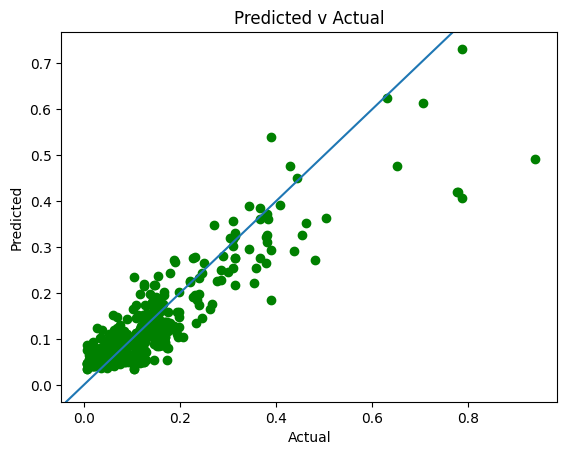

In [38]:
y_pred = model.predict(X_test)
plt.scatter(y_test, y_pred,color='g')
plt.title('Predicted v Actual')
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.axline((0, 0), slope=1)
plt.ticklabel_format(style='plain')
plt.show()

## 2.25 Produce MAE, MSE, RMSE

In [39]:
gb_mae = metrics.mean_absolute_error(y_test, y_pred)
gb_mse = metrics.mean_squared_error(y_test, y_pred)
gb_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.031141818794054685
Mean Squared Error: 0.0023496808872108077
Root Mean Squared Error: 0.04847350706531154


## 2.26 Compare MAE, MSE, and RMSE

In [45]:
tests_data = [['Linear Regression', linear_mae, linear_mse, linear_rmse], ["Polynomial Regression", poly_mae, poly_mse, poly_rmse], ["Linear Neural Net", neural_linear_mae, neural_linear_mse, neural_linear_rmse], ["Neural Network", neural_net_mae, neural_net_mse, neural_net_rmse], ["Gradient Boosting Regression", gb_mae, gb_mse, gb_rmse]]
tests_df = pd.DataFrame(tests_data, columns=['Model', 'MAE', 'MSE', 'RMSE'])
tests_df.head()

mae_ranked = tests_df.sort_values(by='MAE').head()
mse_ranked = tests_df.sort_values(by='MSE').head()
rmse_ranked = tests_df.sort_values(by='RMSE').head()
print("MAE Ranked:")
print(mae_ranked)
print("\nMSE Ranked:")
print(mse_ranked)
print("\nRMSE Ranked:")
print(rmse_ranked)

MAE Ranked:
                          Model       MAE       MSE      RMSE
4  Gradient Boosting Regression  0.031142  0.002350  0.048474
1         Polynomial Regression  0.037510  0.003839  0.061962
3                Neural Network  0.040692  0.004793  0.069231
0             Linear Regression  0.052259  0.006988  0.083593
2             Linear Neural Net  0.059547  0.008406  0.091686

MSE Ranked:
                          Model       MAE       MSE      RMSE
4  Gradient Boosting Regression  0.031142  0.002350  0.048474
1         Polynomial Regression  0.037510  0.003839  0.061962
3                Neural Network  0.040692  0.004793  0.069231
0             Linear Regression  0.052259  0.006988  0.083593
2             Linear Neural Net  0.059547  0.008406  0.091686

RMSE Ranked:
                          Model       MAE       MSE      RMSE
4  Gradient Boosting Regression  0.031142  0.002350  0.048474
1         Polynomial Regression  0.037510  0.003839  0.061962
3                Neural Network